# The standalone SMR plant baseline example and costing anaylsis

SMR, or Steam Methane Reforming, is a process used to produce hydrogen gas from natural gas (primarily methane). In the process, steam and methane are heated to high temperatures (700°C to 1000°C) in the presence of a nickel catalyst, causing the methane to break down into carbon monoxide and hydrogen, which is then separated and purified to produce hydrogen gas. SMR is one of the most common methods for hydrogen production and is widely used in the chemical and oil refining industries. The National Energy Technology Laboratory (NETL) has published a report called "Comparison of Commercial, State of the Art, Fossil Based Hydrogen Production Technologies" which provides an overview of different hydrogen production technologies, including SMR with carbon capture. https://www.osti.gov/biblio/1862910

The simulation of the SMR process with carbon capture in this notebook is based on the SMR process discussed in the NETL report. The simulation is an equation-oriented first principle model using the IDAES integrated platform. The notebook starts from building the simulation and conducting the costing analysis to estimate the production cost of hydrogen.

In addition to the production cost, the notebook also introduces the concept of Levelized Cost of Hydrogen (LCOH), which is a commonly used metric for comparing the cost of hydrogen produced by different technologies. The LCOH takes into account not only the production cost, but also the capital cost, operating costs, and financing costs, over the lifetime of the plant, to estimate the cost of producing one unit of hydrogen. The LCOH is an important factor in determining the feasibility and competitiveness of hydrogen production technologies.

This notebook is a support material of the manuscript titled as "Techno-economic Analysis and Optimization of Low Carbon Reforming Based Integrated Energy Systems for the Co-production of Hydrogen and Power"

## 1. Import the SMR process model

In [2]:
from smr_standalone_plant import get_blue_hydrogen_plant_model as build_smr_plant

## 2. Build the SMR process simualtion

In [3]:
smr_plant_model = build_smr_plant()

Ipopt 3.13.2: tol=1e-07
linear_solver=ma27
max_iter=100
bound_push=1e-16


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes 

## 3. Display the Process Flowsheet Diagram of the SMR process

In the SMR process, natural gas and steam are fed into a reactor, where they are heated to high temperatures (700°C to 1000°C) in the presence of a nickel catalyst. The heat causes the methane to break down into carbon monoxide (CO) and hydrogen (H2), and the reaction can be represented by the following equation: CH4 + H2O → CO + 3H2.

The produced gas mixture then enters a shift reactor, where the carbon monoxide is reacted with water to produce more hydrogen, according to the reaction: CO + H2O → CO2 + H2. The reaction is exothermic and helps to cool the gas mixture before it enters the purification unit.

In the purification unit, the gas mixture is cooled and the hydrogen is separated from the remaining gases using a series of separation steps, such as pressure swing adsorption (PSA) or membrane separation. The purified hydrogen is then collected and can be used for various applications, such as fuel for vehicles or as a feedstock for the production of chemicals and fuels.

To reduce greenhouse gas emissions, carbon capture and storage (CCS) can be integrated into the SMR process. There are two main types of CCS: pre-combustion carbon capture and post-combustion carbon capture. In pre-combustion carbon capture, the carbon dioxide (CO2) is removed from the syngas stream before it is combusted. This can be achieved by separating the CO2 from the syngas using a separation unit, such as a PSA or membrane unit. The captured CO2 can then be compressed and transported for storage or utilization.

In post-combustion carbon capture, the CO2 is captured from the flue gas produced by the combustion of the syngas. This can be achieved by using solvents or adsorbents to capture the CO2 from the flue gas and then separating the CO2 using a separation unit. The captured CO2 can then be compressed and transported for storage or utilization.

The SMR process flowsheet diagram usually consists of a reactor, a shift reactor, a purification unit, and auxiliary equipment such as compressors, heat exchangers, and pumps. The flowsheet diagram illustrates the flow of material and energy in the process and helps to understand the different stages of the SMR process, including the pre-combustion or post-combustion carbon capture, and their interconnections.

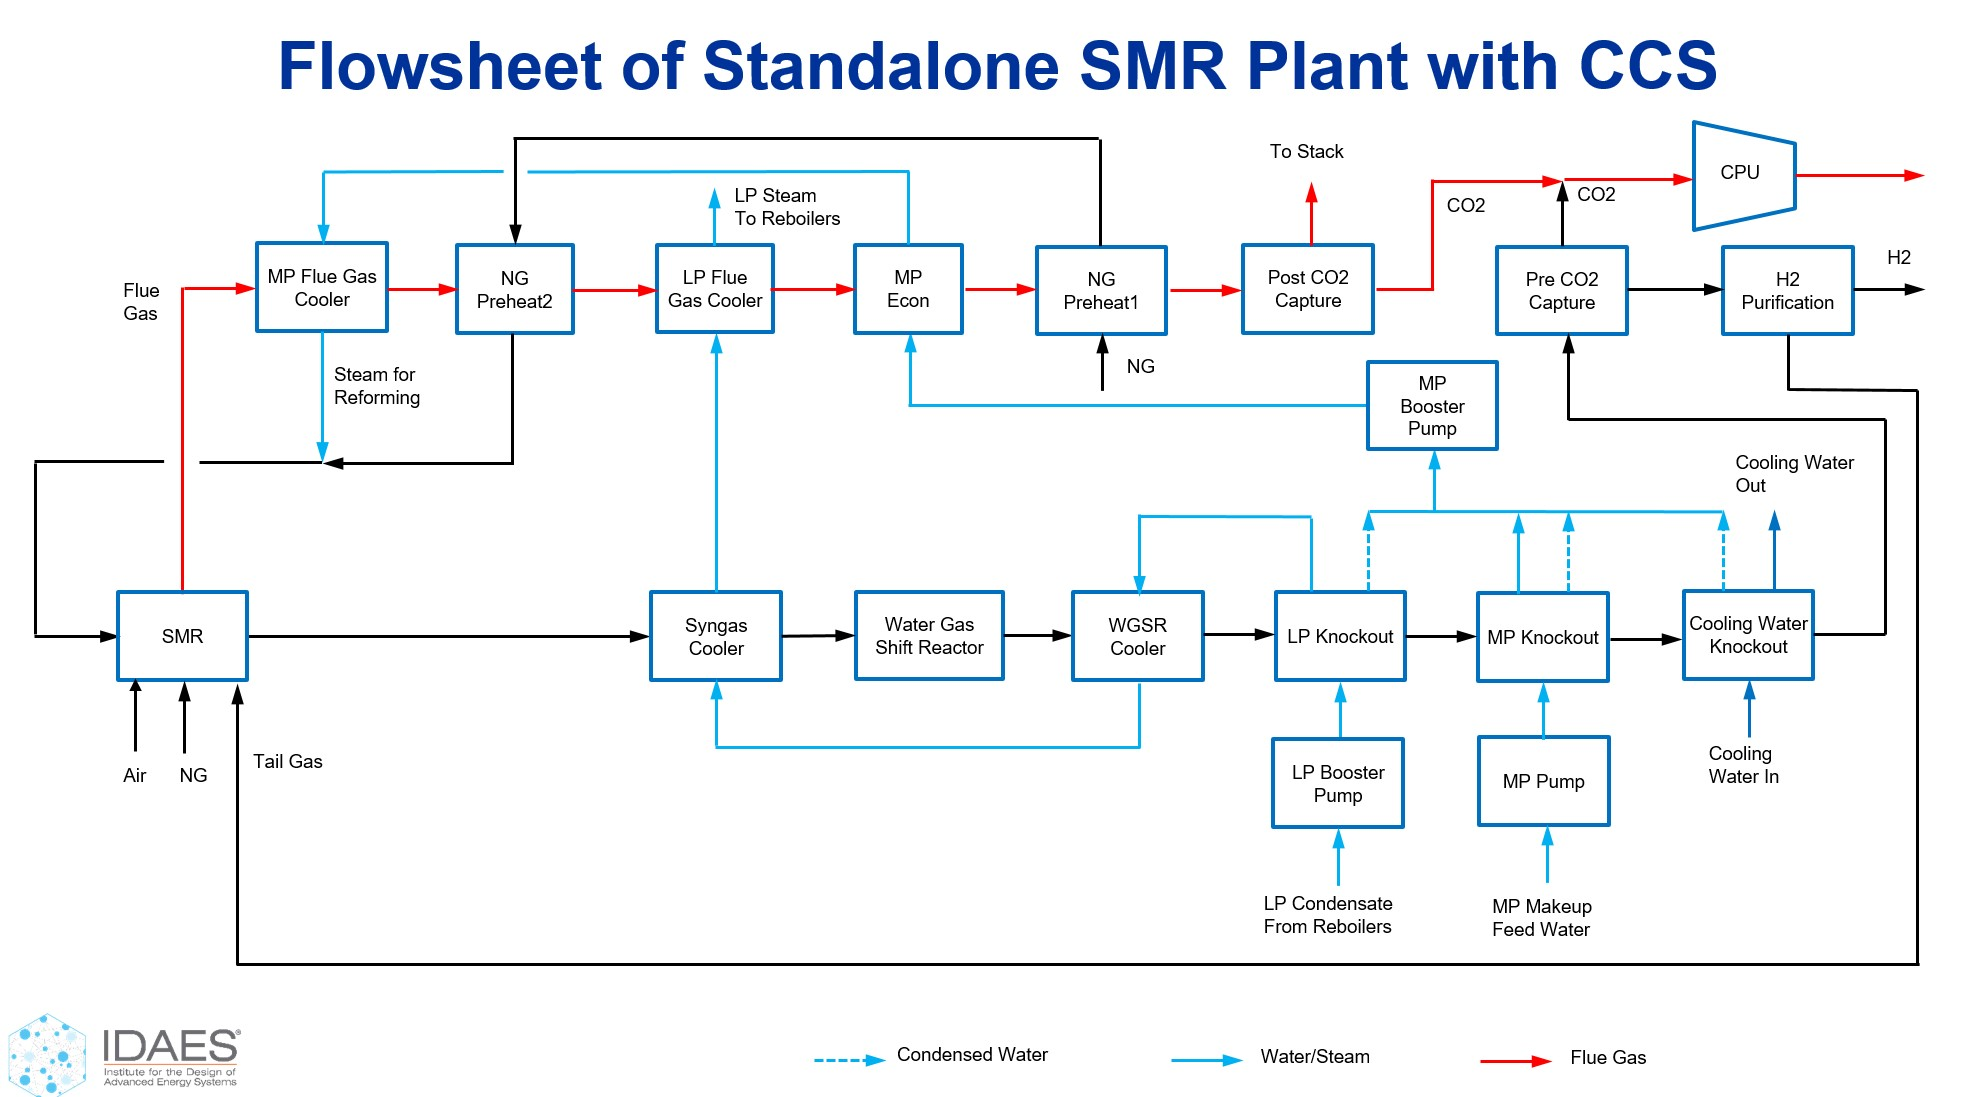

In [4]:
from IPython.display import display, Image
display(Image(filename = "SMR_PFD.jpg"))

## 4.Display the results summary of process simulation

In [5]:
import pandas as pd
import pyomo.environ as pyo

m = smr_plant_model
res = pd.DataFrame(index = ['values'])
res['H2 production Rate (kg/hr)'] = round(
                                    pyo.value(m.fs.h2_separator.h2_outlet.flow_mol[0]*m.fs.h2_separator.h2_outlet_state[0].mw*3600)
                                    ,2)
res['CO2 Product from Pre-combustion Capture (kg/hr)'] = round(
                                                         pyo.value(m.fs.co2_pre_separator.co2_outlet_state[0].flow_mol*m.fs.co2_pre_separator.co2_outlet_state[0].mole_frac_comp['CO2']*44*3.6)
                                                         ,2)

res['CO2 Product from Post-combustion Capture (kg/hr)'] = round(
                                                         pyo.value(m.fs.co2_post_separator.co2_outlet_state[0].flow_mol*m.fs.co2_post_separator.co2_outlet_state[0].mole_frac_comp['CO2']*44*3.6)
                                                         ,2)
res['Flue Gas Flow Rate (kg/s)'] =  round(
                                    pyo.value(m.fs.smr_shell.outlet.flow_mol[0]*m.fs.smr_shell.control_volume.properties_out[0].mw)
                                   ,2)
res['Natural Gas Feed Rate to SMR As Reactant (kg/hr)'] = round(
                                              pyo.value(m.fs.ng_preheat1.tube_inlet.flow_mol[0]*16.5143*3.6)
                                             ,2)
res['Natural Gas Feed Rate to SMR Furnace As Fuel (kg/hr)'] =round(
                                             pyo.value(m.fs.smr_shell_mix.fuel_inlet.flow_mol[0]*16.5143*3.6)
                                            ,2)

res.T

,values
H2 production Rate (kg/hr),20121.67
CO2 Product from Pre-combustion Capture (kg/hr),124014.19
CO2 Product from Post-combustion Capture (kg/hr),70040.96
Flue Gas Flow Rate (kg/s),174.88
Natural Gas Feed Rate to SMR As Reactant (kg/hr),60888.42
Natural Gas Feed Rate to SMR Furnace As Fuel (kg/hr),13852.19


validate the simulation results for testing

In [6]:
import pytest
assert res.at['values','H2 production Rate (kg/hr)'] == pytest.approx(20121.67,rel = 1e-8)
assert res.at['values','Flue Gas Flow Rate (kg/s)'] == pytest.approx(174.88,rel = 1e-8)

## 5. Run the costing analysis of the SMR process

In this work, a sophisticated bottom-up costing framework is built by implementing the methodology originally proposed by National Energy Technology Laboratory (NETL). The NETL costing methodology has been successfully applied in various applications from different types of power plants to hydrogen generation plants. Detailed information about NETL costing methodology is available in the 2019 revision of the Quality Guidelines for Energy System Studies (QGESS) document titled “Cost Estimation Methodology for NETL Assessment of Power Plant Performance.” (Theis, 2019) https://www.osti.gov/biblio/1567736

Import existing functions in the costing.py file and get them ready to use for the costing analysis later

In [7]:
from costing import *

The first step before start to doing the costing analysis is to set the background of the case, which includes the name of the plant and the assumed the capacity factor. In this example, we set the capacity of the SMR plant as 90 %. 

In [8]:
plant = Plant('smr', 0.9)

The second step is to prepare other data for the costing analysis in this case. The assumed power price and fuel price are stored in the price files. They are fixed for the costing analysis in this step. But we will demonstrate the way to release them as degrees of freedoms in the later section. 

In [9]:
case = plant.type
cf = plant.cf
for i in range(len(read_data(plant.files()[case]))):    
    product = pd.read_csv("reference/product.csv", header= 0, index_col = [0,1])
    if case is not None: 
        product[case] = read_data(plant.files()[case])[i]
    product.loc[['co2']] = product.loc[['co2']] /1000
    product.loc[['ng']] = product.loc[['ng']] * 49565.84/1e6
    product.reset_index(inplace = True)
    product.set_index('item',inplace = True,drop = True)
    price = pd.read_csv('reference/price.csv', header = 0, index_col = 0)
    total = pd.DataFrame()
    for col in product.drop('unit', axis = 1).columns:
        for index in price.instant.index:
            total.at[index,col] = product[col][index] * price.instant[index]*24*365/1e6

Based on the input information defined so far, the costing was completed and the levelized cost of hydrogen was used in this work as the key index.

In [10]:
cost= cost_cal(case)
summary = cost_sum(product,total,cost,case,cf)
LCOH = LCOH_cal(summary, product,cf)  

## 6. Summary of costing results using LCOH

Levelized Cost of Hydrogen (LCOH) is a widely used metric to compare the costs of different hydrogen production technologies. LCOH represents the cost of producing one kilogram of hydrogen over the lifetime of the production plant, taking into account all capital costs, operating costs, and the present value of future costs. It is expressed in units of currency per kilogram of hydrogen ($/kg H2).

The calculation of LCOH involves estimating the total costs of the hydrogen production plant over its lifetime, including the investment costs for construction and equipment, the operating costs for materials, labor, energy, and maintenance, and the costs associated with the end-of-life decommissioning of the plant. These costs are then divided by the total amount of hydrogen produced over the lifetime of the plant to obtain the LCOH.

LCOH is a useful metric for comparing different hydrogen production technologies because it accounts for the total cost of producing hydrogen, including both capital and operating costs, and provides a level playing field for comparing the costs of different technologies. It also takes into account the time value of money, meaning that future costs are discounted to present value, so that the costs of the different technologies can be compared over the same period of time.

In [11]:
import pandas as pd
lcoh = pd.read_csv('LCOH.csv', header = 0, index_col = 0) 
print(lcoh)

              Value, $/kg H2
Capital                 0.33
Fixed O&M               0.15
Variable O&M            0.24
Fuel                    0.82
CO2 S&T                 0.10
Total                   1.64


##  7. Plot the bar chart of LCOH

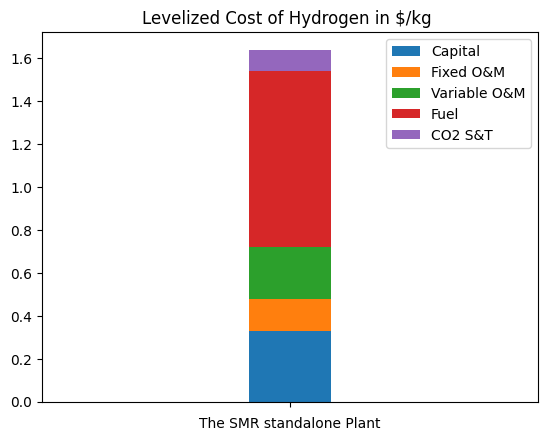

In [12]:
import matplotlib.pyplot as plt

df = pd.DataFrame()
df = lcoh.T.drop('Total', axis = 1)
df['The SMR standalone Plant'] = ''

df.plot(x='The SMR standalone Plant', kind='bar', stacked=True,
        title='Levelized Cost of Hydrogen in $/kg ',
        width = 0.1)
plt.show()


## 8. LCOH sensitivity study on various fuel price

Store the baseline LCOH calculation results at fuel price as $4.42/MMBTU

In [13]:
fp_sen = pd.DataFrame()
fp_sen['fuel price = 4.42'] = LCOH['Value, $/kg H2']

Change the natural gas price to $6/MMBTU

In [14]:
price_sen = pd.read_csv('reference/price.csv', header = 0, index_col = 0)
price_sen.at['ng','instant'] = 6
price_sen.to_csv('reference/price.csv')

complete the new serise of costing analysis in new assumptions

In [15]:
from costing import *
plant = Plant('smr', 0.9)
case = plant.type
cf = plant.cf
for i in range(len(read_data(plant.files()[case]))):    
    product = pd.read_csv("reference/product.csv", header= 0, index_col = [0,1])
    if case is not None: 
        product[case] = read_data(plant.files()[case])[i]
    product.loc[['co2']] = product.loc[['co2']] /1000
    product.loc[['ng']] = product.loc[['ng']] * 49565.84/1e6
    product.reset_index(inplace = True)
    product.set_index('item',inplace = True,drop = True)
    price = pd.read_csv('reference/price.csv', header = 0, index_col = 0)
    total = pd.DataFrame()
    for col in product.drop('unit', axis = 1).columns:
        for index in price.instant.index:
            total.at[index,col] = product[col][index] * price.instant[index]*24*365/1e6
cost= cost_cal(case)
summary = cost_sum(product,total,cost,case,cf)
LCOH_fp = LCOH_cal(summary, product,cf)  
price_sen = pd.read_csv('reference/price.csv', header = 0, index_col = 0)
price_sen.at['ng','instant'] = 4.42
price_sen.to_csv('reference/price.csv')

Plot the sensitivity study results

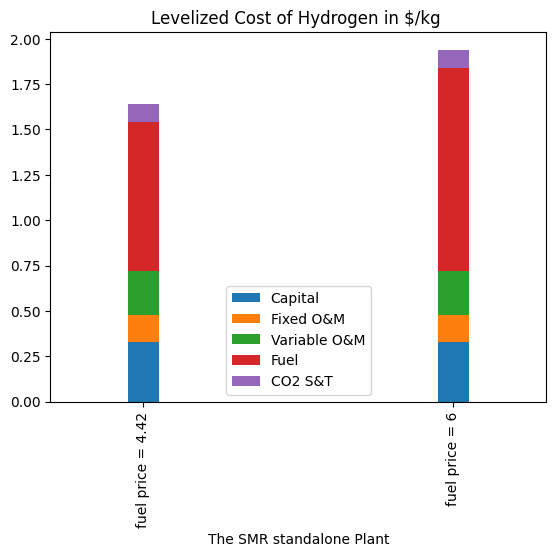

In [16]:
fp_sen['fuel price = 6'] = LCOH_fp['Value, $/kg H2']
df = fp_sen.T.drop('Total', axis = 1)
df['The SMR standalone Plant'] = df.index
df.plot(x='The SMR standalone Plant', kind='bar', stacked=True,
        title='Levelized Cost of Hydrogen in $/kg ',
        width = 0.1)
plt.show()

 sensitivity study with more cases

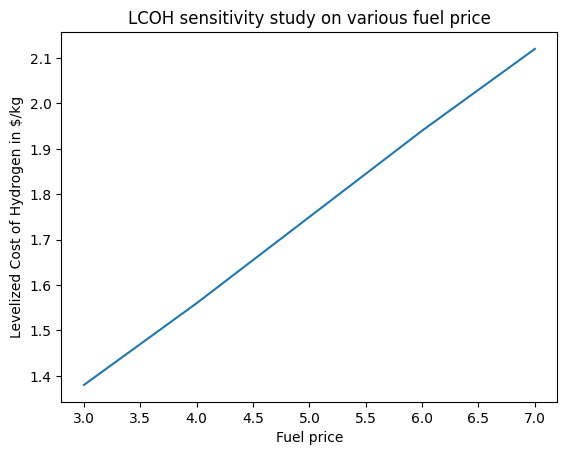

In [17]:
import matplotlib.pyplot as plt
fp_list = list(range(3,8,1))
LCOH_fp_list = []
for fp in fp_list:
    price_sen = pd.read_csv('reference/price.csv', header = 0, index_col = 0)
    price_sen.at['ng','instant'] = fp
    price_sen.to_csv('reference/price.csv')
    plant = Plant('smr', 0.9)
    case = plant.type
    cf = plant.cf
    for i in range(len(read_data(plant.files()[case]))):    
        product = pd.read_csv("reference/product.csv", header= 0, index_col = [0,1])
        if case is not None: 
            product[case] = read_data(plant.files()[case])[i]
        product.loc[['co2']] = product.loc[['co2']] /1000
        product.loc[['ng']] = product.loc[['ng']] * 49565.84/1e6
        product.reset_index(inplace = True)
        product.set_index('item',inplace = True,drop = True)
        price = pd.read_csv('reference/price.csv', header = 0, index_col = 0)
        total = pd.DataFrame()
        for col in product.drop('unit', axis = 1).columns:
            for index in price.instant.index:
                total.at[index,col] = product[col][index] * price.instant[index]*24*365/1e6
    cost= cost_cal(case)
    summary = cost_sum(product,total,cost,case,cf)
    LCOH_fp = LCOH_cal(summary, product,cf)  
    LCOH_fp_list.append(LCOH_fp.at['Total','Value, $/kg H2'])
price_sen = pd.read_csv('reference/price.csv', header = 0, index_col = 0)
price_sen.at['ng','instant'] = 4.42
price_sen.to_csv('reference/price.csv')

plt.plot(fp_list, LCOH_fp_list)
plt.title('LCOH sensitivity study on various fuel price')
plt.xlabel("Fuel price")
plt.ylabel('Levelized Cost of Hydrogen in $/kg')
plt.show()

## 9. LCOH sensitivity study on various capacity factor

Store the baseline LCOH calculation results at capacity factor as 0.9

In [18]:
cp_sen = pd.DataFrame()
cp_sen['capacity factor = 0.9'] = LCOH['Value, $/kg H2']

complete the new serise of costing analysis in new assumptions

In [19]:
from costing import *
plant = Plant('smr', 0.8)
case = plant.type
cf = plant.cf
for i in range(len(read_data(plant.files()[case]))):    
    product = pd.read_csv("reference/product.csv", header= 0, index_col = [0,1])
    if case is not None: 
        product[case] = read_data(plant.files()[case])[i]
    product.loc[['co2']] = product.loc[['co2']] /1000
    product.loc[['ng']] = product.loc[['ng']] * 49565.84/1e6
    product.reset_index(inplace = True)
    product.set_index('item',inplace = True,drop = True)
    price = pd.read_csv('reference/price.csv', header = 0, index_col = 0)
    total = pd.DataFrame()
    for col in product.drop('unit', axis = 1).columns:
        for index in price.instant.index:
            total.at[index,col] = product[col][index] * price.instant[index]*24*365/1e6
cost= cost_cal(case)
summary = cost_sum(product,total,cost,case,cf)
LCOH_cp = LCOH_cal(summary, product,cf)  

Plot the sensitivity study results

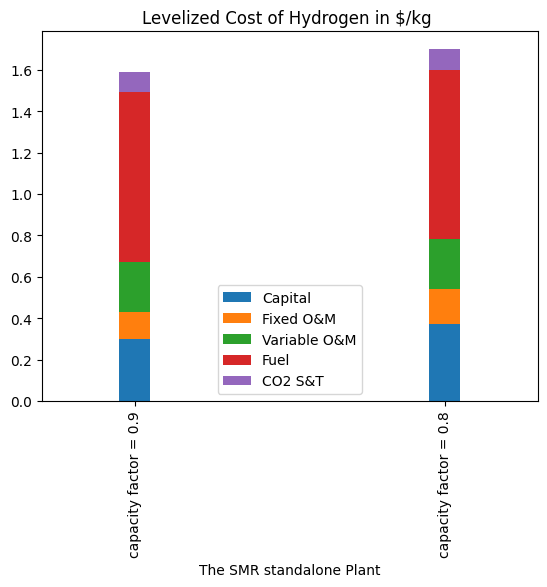

In [20]:
cp_sen['capacity factor = 0.8'] = LCOH_cp['Value, $/kg H2']
df = cp_sen.T.drop('Total', axis = 1)
df['The SMR standalone Plant'] = df.index
df.plot(x='The SMR standalone Plant', kind='bar', stacked=True,
        title='Levelized Cost of Hydrogen in $/kg ',
        width = 0.1)
plt.show()

 sensitivity study with more cases

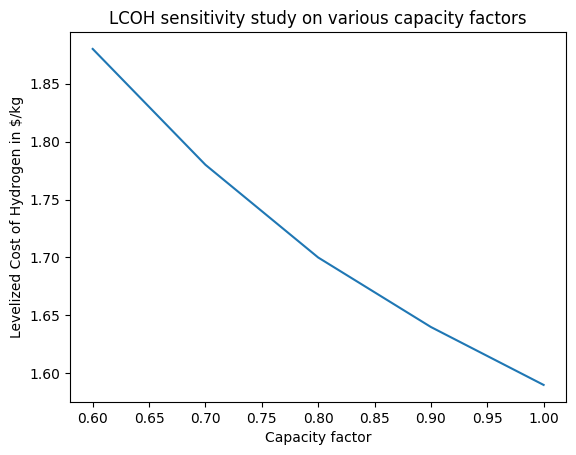

In [20]:
import matplotlib.pyplot as plt
cp_list = list(range(60,105,10))
LCOH_cp_list = []
for cp in cp_list:
    plant = Plant('smr', cp/100)
    case = plant.type
    cf = plant.cf
    for i in range(len(read_data(plant.files()[case]))):    
        product = pd.read_csv("reference/product.csv", header= 0, index_col = [0,1])
        if case is not None: 
            product[case] = read_data(plant.files()[case])[i]
        product.loc[['co2']] = product.loc[['co2']] /1000
        product.loc[['ng']] = product.loc[['ng']] * 49565.84/1e6
        product.reset_index(inplace = True)
        product.set_index('item',inplace = True,drop = True)
        price = pd.read_csv('reference/price.csv', header = 0, index_col = 0)
        total = pd.DataFrame()
        for col in product.drop('unit', axis = 1).columns:
            for index in price.instant.index:
                total.at[index,col] = product[col][index] * price.instant[index]*24*365/1e6
    cost= cost_cal(case)
    summary = cost_sum(product,total,cost,case,cf)
    LCOH_cp = LCOH_cal(summary, product,cf)    
    LCOH_cp_list.append(LCOH_cp.at['Total','Value, $/kg H2'])
    
plt.plot([x/100 for x in cp_list], LCOH_cp_list)
plt.title('LCOH sensitivity study on various capacity factors')
plt.xlabel("Capacity factor")
plt.ylabel('Levelized Cost of Hydrogen in $/kg')
plt.show()

## 10. LCOH sensitivity study on various power price

create the power price list from $30 to $100/MWh

In [21]:
pp_list = list(range(30,100,10))
LCOH_pp_list = []

In [22]:
from costing import *
plant = Plant('smr', 0.9)
case = plant.type
cf = plant.cf
for i in range(len(read_data(plant.files()[case]))):    
    product = pd.read_csv("reference/product.csv", header= 0, index_col = [0,1])
    if case is not None: 
        product[case] = read_data(plant.files()[case])[i]
    product.loc[['co2']] = product.loc[['co2']] /1000
    product.loc[['ng']] = product.loc[['ng']] * 49565.84/1e6
    product.reset_index(inplace = True)
    product.set_index('item',inplace = True,drop = True)
    price = pd.read_csv('reference/price.csv', header = 0, index_col = 0)
    total = pd.DataFrame()
    for col in product.drop('unit', axis = 1).columns:
        for index in price.instant.index:
            total.at[index,col] = product[col][index] * price.instant[index]*24*365/1e6
for pp in pp_list:
    ppr = pp / 71.7
    cost= cost_cal(case, ppr)
    summary = cost_sum(product,total,cost,case,cf)
    LCOH_pp = LCOH_cal(summary, product,cf)
    LCOH_pp_list.append(LCOH_pp.at['Total','Value, $/kg H2'])

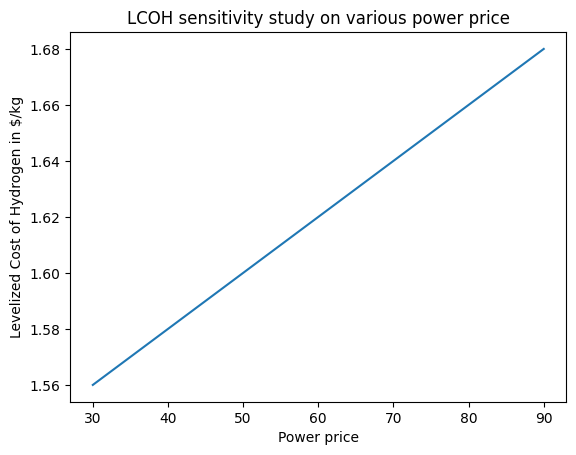

In [23]:
import matplotlib.pyplot as plt
plt.plot(pp_list, LCOH_pp_list)
plt.title('LCOH sensitivity study on various power price')
plt.xlabel("Power price")
plt.ylabel('Levelized Cost of Hydrogen in $/kg')
plt.show()

# Summary

This notebook serves as an example of a standalone SMR (steam methane reforming) plant baseline case and its associated costing analysis. The notebook includes a step-by-step guide to building an SMR process simulation and the attached flowsheet diagram provides a visual representation of the process. The notebook also includes testing to validate results, ensuring accuracy in the analysis. The costing analysis is completed for the baseline case using the LCOH (levelized cost of hydrogen) index, and a categorized bar chart is plotted to provide a clear visual representation of the costs. Additionally, the notebook includes a sensitivity study that explores the impact of various fuel prices, plant capacity factors, and power prices on the overall cost of hydrogen production. This notebook serves as a supporting material for a published paper, providing readers with a detailed guide to the SMR plant baseline case and the associated costing analysis